In [546]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn 
import plotly.express as px

# Домашняя работа: деревья решений

В этой домашней работе вам предстоит научиться предсказывать цены товаров из маркетплейса Azamon.

Требования к домашней работе:
- Во всех графиках должны быть подписи через title, legend, etc.
- Во время обучения моделей проверяйте, что у вас не текут данные. Обычно это позитивно влияет на качество модели на тесте, но негативно влияет на оценку 🌚
- Если вы сдаете работу в Google Colaboratory, убедитесь, что ваша тетрадка доступна по ссылке.
- Использование мемов допускается, но необходимо соблюдать меру. Несодержательная работа, состоящая только из мемов, получает 0 баллов.

***
# ***1. Загрузим данные с диска***
***

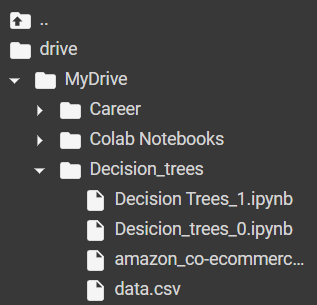

In [621]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Decision_trees/amazon_co-ecommerce_sample.csv').drop(columns=[
    'product_name',
    'index',
    'uniq_id',
    'customers_who_bought_this_item_also_bought',
    'items_customers_buy_after_viewing_this_item',
    'sellers',
    'description', # text
    'product_information', # text
    'product_description', # text
    'customer_questions_and_answers', # text
    'customer_reviews', # text
])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***
# ***2. Очистка данных (1 балл)***

Посмотрите на признаки. Есть ли в них пропуски? Какое соотношение между NaN'ами и общим количеством данных? Есть ли смысл выкидывать какие-либо данные из этого датасета?

***

- Узнаем количество признаков и колонок;
- Узнаем число NaN`ов;
- Найдём пропуски;
- Сделаем вывод, что делать с датасетом.

In [622]:
print("Total features & columns:", df.shape, "\n")
print(df.isna().sum(), "\n")
print("Total NaN`s:", df.isna().sum().sum())

Total features & columns: (10000, 7) 

manufacturer                           7
price                               1435
number_available_in_stock           2500
number_of_reviews                     18
number_of_answered_questions         765
average_review_rating                 18
amazon_category_and_sub_category     690
dtype: int64 

Total NaN`s: 5433


- Суммарно 5433 пропусков. В категориях сильнее всего выделяются показатели "ценовой" (1453) и "в наличии" (2500).
- Посмотрим, как они представлены в таблице.

In [623]:
print(df.head())
print(df.info())

  manufacturer   price number_available_in_stock number_of_reviews  \
0       Hornby   £3.42                     5 new                15   
1    FunkyBuys  £16.99                       NaN                 2   
2          ccf   £9.99                     2 new                17   
3       Hornby  £39.99                       NaN                 1   
4       Hornby  £32.19                       NaN                 3   

   number_of_answered_questions average_review_rating  \
0                           1.0    4.9 out of 5 stars   
1                           1.0    4.5 out of 5 stars   
2                           2.0    3.9 out of 5 stars   
3                           2.0    5.0 out of 5 stars   
4                           2.0    4.7 out of 5 stars   

                    amazon_category_and_sub_category  
0  Hobbies > Model Trains & Railway Sets > Rail V...  
1  Hobbies > Model Trains & Railway Sets > Rail V...  
2  Hobbies > Model Trains & Railway Sets > Rail V...  
3  Hobbies > Mod

- Форма представления доступных предметов "5 new" будет нам мешать.
- Думаю, её можно будет удалить, так как примерно половину всех NaN`ов составляет именно этот столбец.

In [624]:
df = df.drop(columns = ['number_available_in_stock'])

In [625]:
#data_median = df['number_available_in_stock'].median()
#print(data_median)
#df['number_available_in_stock'] = df['number_available_in_stock'].fillna(data_median)

- Однако просто так не получилось привести пропущенные данные к медиане, т.к. они не числовые. Нужно будет поработать с этим.
- А отбросить дубликаты будет не совсем корректно. И, как оказалось, не отбросятся NaN.

In [626]:
## удаляем дубликаты
#df_dedupped = df.drop('number_available_in_stock', axis=1).drop_duplicates()

# сравниваем формы старого и нового наборов
#print(df.shape, "\n")
#print(df_dedupped.shape, "\n")

#print(df.isna().sum(), "\n")

#key = ['number_available_in_stock', 'price', 'number_of_reviews', 'number_of_answered_questions', 'average_review_rating', 'amazon_category_and_sub_category']
#df_dedupped2 = df.drop_duplicates(subset=key)

#print(df.shape)
#print(df_dedupped2.shape)
#print("\n", df.isna().sum())

***
# ***3. Подготовка данных (3 балла)***

Обработайте признаки. Выполните кодирование категориальных признаков, заполните пропуски в числовых признаках. Обратите внимание, что в датасете есть признак, который разбивается на несколько подпризнаков. Что это за признак? Закодируйте и его.

Дополнительные вопросы (+ 1 балл):
- Какие из признаков в этом датасете лучше кодировать через ordinal encoding?
- Какие из признаков допустимо кодировать через one-hot?

Прим.: суммарно за эту секцию можно получить до 4 баллов.
***

- Посмотрим на категории датасета, чтобы выбрать подходящие методы кодирования.
- Для заполнения пропусков в числовых признаках буду использовать подстановку медианных значений вместо NaN`ов. Но в начале мы выяснили, что в документе данные представлены строками, поэтому сначала придётся перевести их в числовой вид.


In [627]:
print(df.isna().sum(), "\n")
print(df.head())

manufacturer                           7
price                               1435
number_of_reviews                     18
number_of_answered_questions         765
average_review_rating                 18
amazon_category_and_sub_category     690
dtype: int64 

  manufacturer   price number_of_reviews  number_of_answered_questions  \
0       Hornby   £3.42                15                           1.0   
1    FunkyBuys  £16.99                 2                           1.0   
2          ccf   £9.99                17                           2.0   
3       Hornby  £39.99                 1                           2.0   
4       Hornby  £32.19                 3                           2.0   

  average_review_rating                   amazon_category_and_sub_category  
0    4.9 out of 5 stars  Hobbies > Model Trains & Railway Sets > Rail V...  
1    4.5 out of 5 stars  Hobbies > Model Trains & Railway Sets > Rail V...  
2    3.9 out of 5 stars  Hobbies > Model Trains & Railway Sets 


- Категория ***manufacturer*** состоит из 7 признаков. Их меньше всего, и для таких целей подойдёт кодировка ***one-hot***. Но нам ни к чему текстовая категория ***manufacturer***, мы от неё избавимся.
- ***amazon_category_and_sub_category*** разбивается на несколько подпризнаков, значит используем для неё ***ordinal encoding***.

In [628]:
columns = df['amazon_category_and_sub_category'].str.split(' > ', expand=True)
columns = columns.fillna("Unknown")
df = df.drop('amazon_category_and_sub_category', axis=1)
df = df.join(pd.get_dummies(df['manufacturer']))
df = df.drop('manufacturer', axis=1)

In [629]:
def price_median(string):
  try:
    elem = string.split('-')
    if len(elem) == 1:
      price1, price2 = elem[0].strip()[1:].replace(",", ""), elem[0].strip()[1:].replace(",", "")
    else:
      price1, price2 = elem[0].strip()[1:].replace(",", ""), elem[1].strip()[1:].replace(",", "")
    return (float(price1) + float(price2)) / 2
  except (ValueError, AttributeError):
    pass

def nan_replace(col):
  df[col] = pd.to_numeric(df[col], errors='coerce')
  mean_var = df[col].mean()
  df[col].fillna(mean_var, inplace=True)


df['price'] = df['price'].map(price_median)
df['average_review_rating'] = df['average_review_rating'].str.split(expand=True)[0].astype(float)

for col in ['price', 'number_of_reviews', 'number_of_answered_questions', 'average_review_rating']:
  nan_replace(col)


In [630]:
df.describe(include = "all")

,price,number_of_reviews,number_of_answered_questions,average_review_rating,101,13,16th Birthday 16th Foil Banner - 9ft,1st birthday,2-in-1 Chess & Draughts,24 Game,...,ukgiftstoreonline,unbespielt,uni-ball,unisex party bag fillers,universal hobby,woooow doll,xs-party,yugioh,zizzi,|MFG
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.0000,10000.0000,10000.000000,10000.0000,10000.0000,...,10000.000000,10000.0000,10000.0000,10000.0000,10000.000000,10000.0000,10000.0000,10000.000000,10000.000000,10000.0000
mean,21.277876,8.897395,1.834976,4.707283,0.0001,0.0001,0.0001,0.000200,0.0001,0.0001,...,0.000200,0.0001,0.0001,0.0001,0.001400,0.0001,0.0001,0.000400,0.000200,0.0001
std,91.917691,28.913888,2.419057,0.371943,0.0100,0.0100,0.0100,0.014141,0.0100,0.0100,...,0.014141,0.0100,0.0100,0.0100,0.037392,0.0100,0.0100,0.019997,0.014141,0.0100
min,0.010000,1.000000,1.000000,2.300000,0.0000,0.0000,0.0000,0.000000,0.0000,0.0000,...,0.000000,0.0000,0.0000,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0000
25%,5.950000,1.000000,1.000000,4.500000,0.0000,0.0000,0.0000,0.000000,0.0000,0.0000,...,0.000000,0.0000,0.0000,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0000
50%,12.990000,2.000000,1.000000,5.000000,0.0000,0.0000,0.0000,0.000000,0.0000,0.0000,...,0.000000,0.0000,0.0000,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0000
75%,21.277876,6.000000,2.000000,5.000000,0.0000,0.0000,0.0000,0.000000,0.0000,0.0000,...,0.000000,0.0000,0.0000,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0000
max,8140.300000,802.000000,39.000000,5.000000,1.0000,1.0000,1.0000,1.000000,1.0000,1.0000,...,1.000000,1.0000,1.0000,1.0000,1.000000,1.0000,1.0000,1.000000,1.000000,1.0000


***
# ***4. Обучение модели (3 балла)***


***
## ***4.1 Бейзлайн***

Обучите базовую модель. Для этого используйте `sklearn.dummy.DummyRegressor`. Какое качество она показывает на тесте? Посчитайте MSE, RMSE.
***

In [631]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['price'])
Y = df['price']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.7)

In [632]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score

dummy_regressor = DummyRegressor()
dummy_regressor.fit(Xtrain, Ytrain)
Ypred = dummy_regressor.predict(Xtest)

mse = mean_squared_error(Ytest, Ypred)
rmse = np.sqrt(mean_squared_error(Ytest,Ypred))

print("MSE value:", mse, "\n")
print("RMSE value:", rmse, "\n")

MSE value: 977.960125645044 

RMSE value: 31.272354015088855 



***
## ***4.2 Дерево решений***

Обучите регрессионное дерево решений, проверьте качество этой модели на тестовой выборке. Улучшилось ли качество по сравнению с базовой моделью? Оцените r2_score обученной модели.
***

In [633]:
from sklearn.tree import DecisionTreeRegressor

DecisionTree = DecisionTreeRegressor()
DecisionTree = DecisionTree.fit(Xtrain, Ytrain)

Yprediction = DecisionTree.predict(Xtest)
print("MSE value:", mean_squared_error(Ytest, Yprediction), "\n")
print("RMSE value:", np.sqrt(mean_squared_error(Ytest, Yprediction)), "\n")
print("r2_score value:", r2_score(Ytest, Yprediction), "\n")

MSE value: 1748.091182607876 

RMSE value: 41.81018037042983 

r2_score value: -0.7920375883697002 



- Значения MSE и RMSE возрасли в сравнении с DummyRegressor.

***
## ***4.3 Линейная регрессия***

Попробуйте обучить линейную регрессию с параметрами по умолчанию. Оцените r2_score на тестовой выборке. Сравните качество с деревом решений.
*** 

In [634]:
from sklearn.linear_model import LinearRegression

Var_linear = LinearRegression()
Var_linear = Var_linear.fit(Xtrain, Ytrain)

Yprediction = Var_linear.predict(Xtest)
print("MSE value:", mean_squared_error(Ytest, Yprediction), "\n")
print("RMSE value:", np.sqrt(mean_squared_error(Ytest, Yprediction)), "\n")
print("r2_score value:", r2_score(Ytest, Yprediction), "\n")

MSE value: 1.7637135046486467e+22 

RMSE value: 132804875838.52661 

r2_score value: -1.8080526501657975e+19 



- Значения модели пришли в некорректный вид. Выходит, что модель загрязнилась данными. Значит, мною была поставлена неверная гипотеза/пошёл не тем путем, анализируя данные.

***
# ***5. Гиперпараметры (2 балла)***

Переберите несколько гиперпараметров (не более двух-трёх). Обратите внимание, как эти параметры влияют на ошибку модели на тестовой выборке. Постройте для глубины дерева график переобучения (fitting curve) аналогичный тому, что мы строили на занятии. Найдите глубину дерева, начиная с которой модель начинает переобучаться.
***

- Для этих целей надо воспользоваться библиотекой seaborn.

Функция выглядит примерно так:

```python
two_arrays = [s.to_numpy() for s in two_series]
sns.relplot(data=two_arrays, kind="line")
```


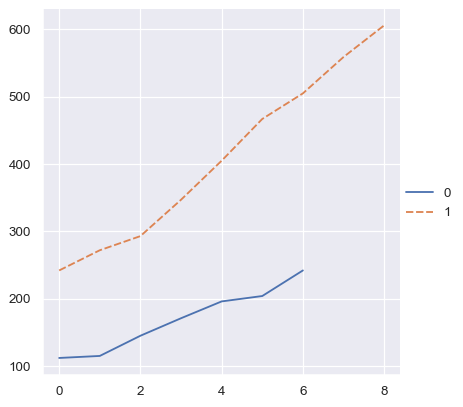


***
# ***6. Простое ансамблирование (1 балл)***

В этой секции мы реализуем простой ансамбль деревьев.


In [635]:
class EnsembleTreeRegressor:
    def __init__(self, num_trees=5, samples_frac=0.8, **model_kwargs):
        self.num_trees= num_trees
        self._samples_frac = 0.8
        self._trees = [DecisionTreeRegressor(**model_kwargs) for _ in range(num_trees)]
    def fit(self, x, y: pd.Series):
        x = pd.DataFrame(x)
        y = y.reset_index(drop=True)
        for tree in self._trees:
            tree_x = x.sample(frac=self._samples_frac, random_state=42)
            tree_y = y[tree_x.index]
            tree.fit(tree_x, tree_y)
        return self

    def predict(self, x: pd.DataFrame):
        x = pd.DataFrame(x)
        res = []
        for i in range(self.num_trees):
          res.append(self._trees[i].predict(x))
        return sum(res) / len(res)

Проверьте, работает ли этот ансамбль лучше обычного дерева с параметрами по умолчанию?

Дополнительно переберите максимальную глубину дерева. Проверьте, насколько отличается момент начала переобучения у одиночного дерева и у ансамбля. Зависит ли этот момент от числа деревьев (`num_trees`)? От числа примеров для каждого дерева (`samples_frac`)? Постройте график fitting curve.
***

In [636]:
EnsembleTree = EnsembleTreeRegressor()
EnsembleTree = EnsembleTree.fit(Xtrain, Ytrain)

Yprediction = EnsembleTree.predict(Xtest)
print("MSE value:", mean_squared_error(Ytest, Yprediction), "\n")
print("RMSE value:", np.sqrt(mean_squared_error(Ytest, Yprediction)), "\n")
print("r2_score value:", r2_score(Ytest, Yprediction), "\n")

KeyError: ignored